<a href="https://colab.research.google.com/github/RfZafar/RFleo/blob/master/Multi_Variate_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
import pandas
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

#import training / testing csv file:
train_data = pandas.read_csv(r'/content/train.csv')
test_data = pandas.read_csv(r'/content/test.csv')

In [106]:
#Statistical Info of Data: 
statistics = train_data.describe() #statistical info about the data: Percentile, mean,max_value etc
header = train_data.head()#header
features = (train_data.columns)#column names
data_types = train_data.dtypes.value_counts()#data-types counts

In [107]:
### Data Cleaning   #######

#seperation of cols:(Numerical data/Categorical data)
num_vars_train = train_data.columns[train_data.dtypes != 'object']
cat_vars_train = train_data.columns[train_data.dtypes == 'object']
num_vars_test = test_data.columns[test_data.dtypes != 'object']
cat_vars_test = test_data.columns[test_data.dtypes == 'object']

#Checking nan values in each feature-column:(Ascending order)
nan_train = train_data.isnull().sum().sort_values(ascending=False)
nan_test = test_data.isnull().sum().sort_values(ascending=False)

#percent of missing data for each column:
null_data_train = train_data.isnull().sum().sort_values(ascending=False)/len(train_data)
missing_data_train = pandas.concat([nan_train,null_data_train],axis=1,keys=['Total nan','Percent'])
null_data_test = test_data.isnull().sum().sort_values(ascending=False)/len(test_data)
missing_data_test = pandas.concat([nan_test,null_data_test],axis=1,keys=['Total nan','Percent'])

#cols with more than 1000 nan enteries are omited):(Id col is also removed)
train_clean = train_data.loc[:, ~train_data.columns.isin(['PoolQC', 'MiscFeature','Alley','Fence'])]
test_clean = test_data.loc[:, ~test_data.columns.isin(['Id','PoolQC', 'MiscFeature','Alley','Fence'])]

#converting the categorical data to numerical for consistency: (Dummy variable Method)
for col_name in train_clean.columns:  #(if the data_type of column is object then convert them)
    if(train_clean[col_name].dtype == 'object'):
        train_clean[col_name]= train_clean[col_name].astype('category')  #Assigning dtype as 'category'
        train_clean[col_name] = train_clean[col_name].cat.codes.sort_values(ascending=False)   #Category coding
#Same for Testing Data: because training / Testing don't have same col numbers
for col_name in test_clean.columns: 
    if(test_clean[col_name].dtype == 'object'):
        test_clean[col_name]= test_clean[col_name].astype('category')  
        test_clean[col_name] = test_clean[col_name].cat.codes.sort_values(ascending=False)  
## cols containing more than 1000 NAN , Null-values are removed, data is shifted to numerical domain (Only int , flaot dtypes with different precision i.e.,8,32,64-bit).

#Replace Remaning nan values by zeroes:
train_clean = train_clean.replace(np.nan, 0)
test_clean = test_clean.replace(np.nan, 0)

Skewness: 1.882876
Kurtosis: 6.536282


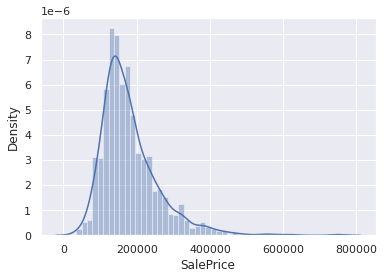

In [108]:
#Descriptive analysis of SalePrice-feature:
#histogram:(Deviation from normal disttribution,+ive skewness,peakedness)
sns.distplot(train_clean['SalePrice']);
#Skewness and Kurtosis: (Skewness:shows lack of symmetry on either side of center point)
#kurtosis:Heavy tail or light tail w.r.t to normal distribution
print("Skewness: %f" % train_clean['SalePrice'].skew())
print("Kurtosis: %f" % train_clean['SalePrice'].kurt())

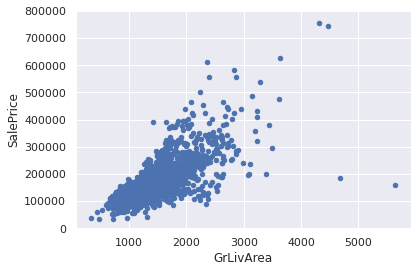

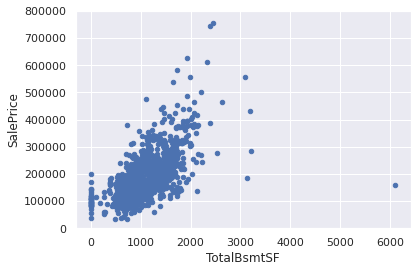

In [109]:
#Relationship of SalePrice with numerical features:
# scatter plot bw grlivarea / saleprice: Linear relationship
data = pandas.concat([train_clean['SalePrice'], train_clean['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0,800000));
#Saleprice / TotalBsmtSF: steep Linear relationship
data = pandas.concat([train_clean['SalePrice'], train_clean['TotalBsmtSF']], axis=1)
data.plot.scatter(x='TotalBsmtSF', y='SalePrice', ylim=(0,800000));

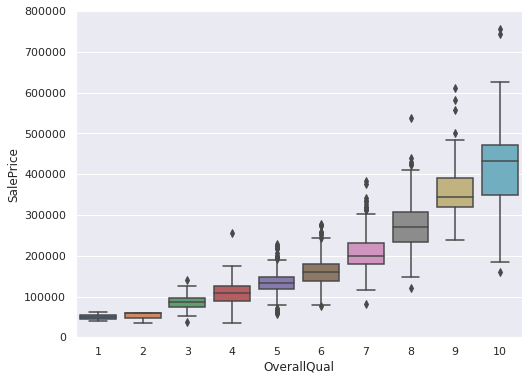

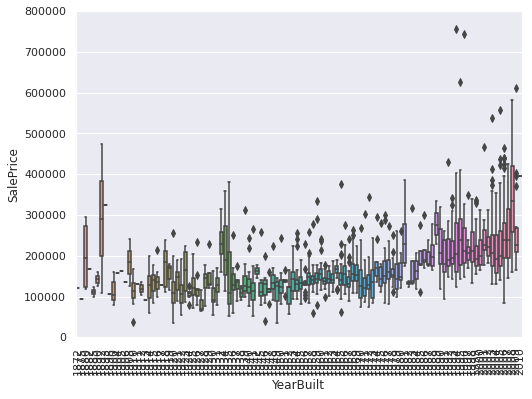

In [110]:
# Relationship of SalePrice with categorical features
#box plot of overallqual / saleprice:(Linear)
#Box plot: Divides the data to 4-portions i.e., 25 % each:(1st quartile, 2nd Quartile, 3rd quartile 4th Quartile) Quartile shows the total density of a variable lying below  
data = pandas.concat([train_clean['SalePrice'], train_clean['OverallQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='OverallQual', y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

#Salesprice vs year_built:(Almost flat relation)
data = pandas.concat([train_clean['SalePrice'], train_clean['YearBuilt']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='YearBuilt', y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

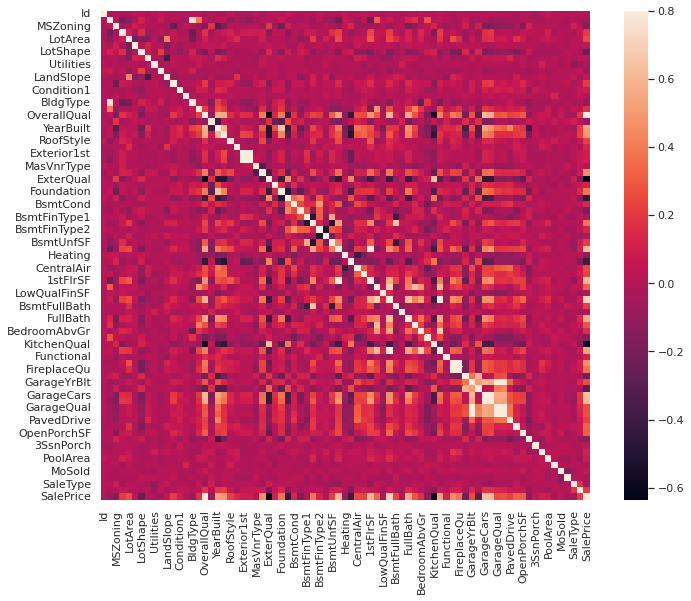

In [111]:
#Correlation bw features:(returns 1 with itself, doesn't consider nan/categorical values)
#correlation matrix
corrmat = train_clean.corr()
f, ax = plt.subplots(figsize=(12, 9))
#Plot rectangular data as a color-encoded matrix.
sns.heatmap(corrmat, vmax=.8, square=True); #vmax,vmin:Values to anchor the colormap, Display the values bw vmax-vmin

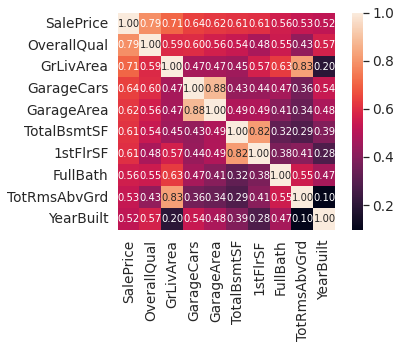

In [112]:
# SalePrice - correlation matrix (zoomed heatmap style)
#top 9-most correlated features of saleprice:
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_clean[cols].values.T)#taking corraltion of 10-features chosen
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

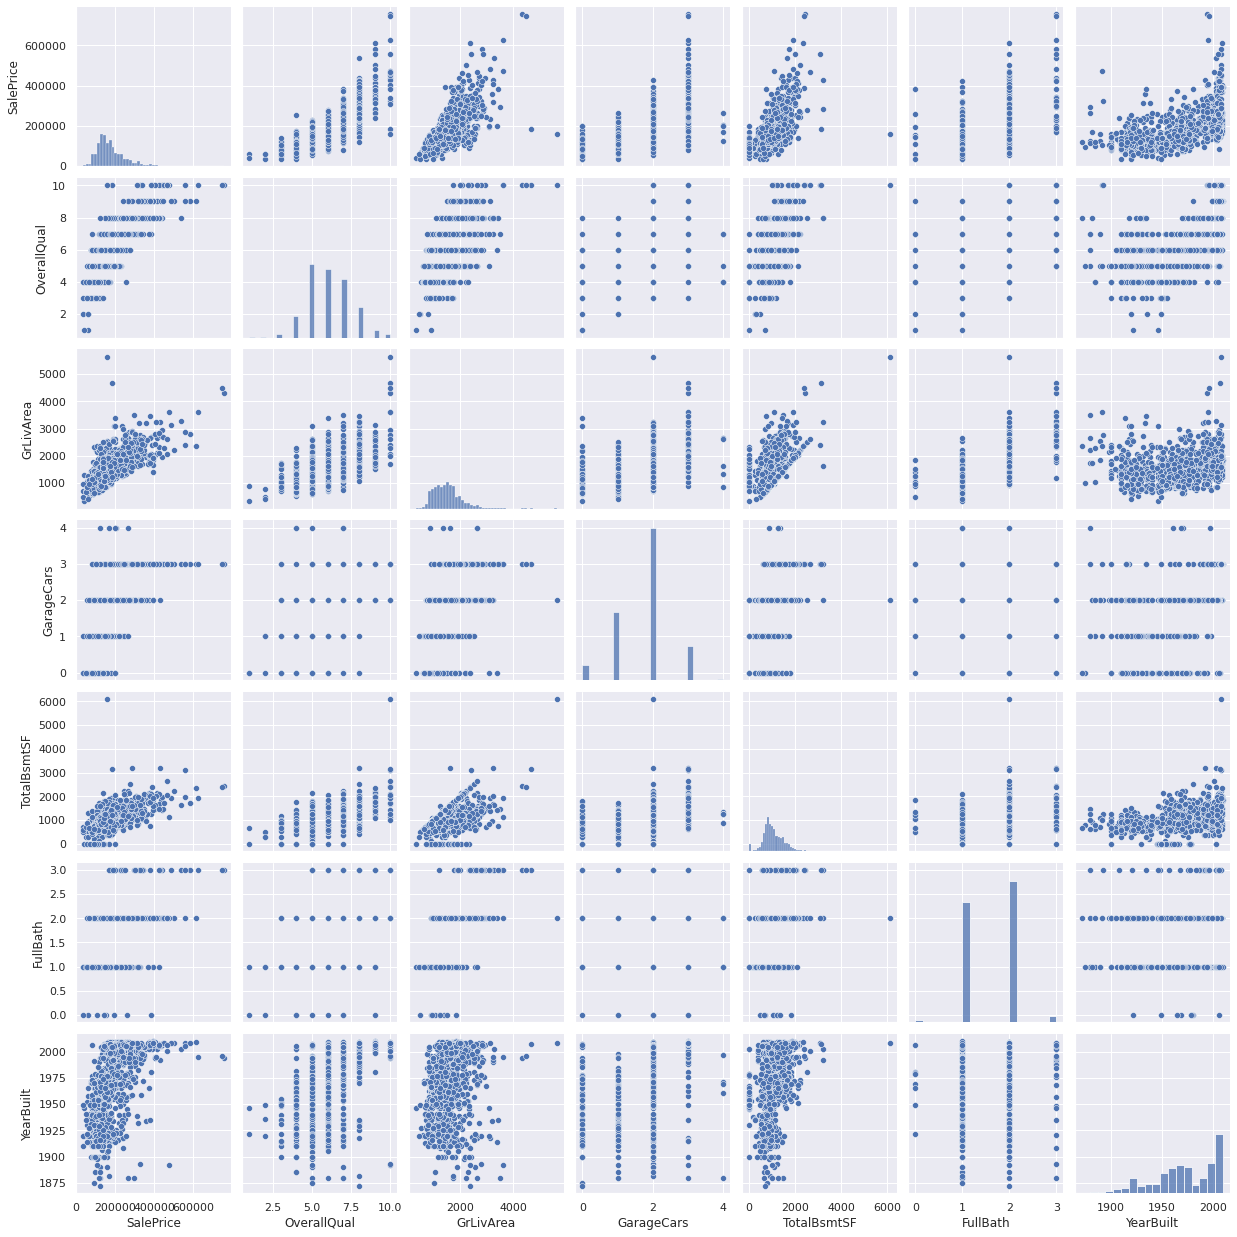

In [113]:
#scatterplot bw top 9 features and salesprice:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train_clean[cols], size = 2.5) #Plot pairwise relationships in a dataset.
plt.show();

In [114]:
# Outliars: Univariate
# standardizing the data:(Converting to Standard Normal distribution)
# No outliars:bcz all values are compact with each other.Least and largest both
saleprice_scaled = StandardScaler().fit_transform(train_clean['SalePrice'][:,np.newaxis]);#np.newaxis:used to make explicit row/column vector
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10] #10-lowest values , argsort():Returns the indices that would sort an array.
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]#values[indeces of 10-largest values]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83870376]
 [-1.83352844]
 [-1.80092766]
 [-1.78329881]
 [-1.77448439]
 [-1.62337999]
 [-1.61708398]
 [-1.58560389]
 [-1.58560389]
 [-1.5731    ]]

outer range (high) of the distribution:
[[3.82897043]
 [4.04098249]
 [4.49634819]
 [4.71041276]
 [4.73032076]
 [5.06214602]
 [5.42383959]
 [5.59185509]
 [7.10289909]
 [7.22881942]]


In [115]:
# Bivariate analysis:(salesprice vs GrlivArea)
# Deleting the 2-islolated points:(Doesn't follow linear relation)
GrLiArea_sort=train_clean.sort_values(by = 'GrLivArea', ascending = False)[:2]
train_clean = train_clean.drop(train_clean[train_clean['Id'] == 1299].index)
train_clean = train_clean.drop(train_clean[train_clean['Id'] == 524].index)

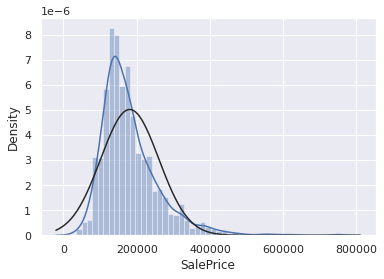

<Figure size 432x288 with 0 Axes>

In [116]:
#Multivariate technique:(It explains Normality,Homoscedasticity, Linearity, Absence of correlated errors)
#2-Homoscedasticity: assumption that dependent variable(s) exhibit equal levels of variance across the range of predictor variable(s)
#also,both the dependant / independent variables would have same amount of error/noise

sns.distplot(train_clean['SalePrice'], fit=norm); #comparison of sample distribution with normal distribution
fig = plt.figure()

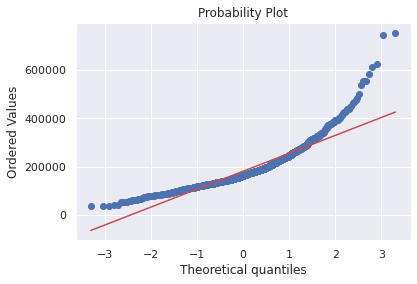

In [117]:
# probability plot of sample data: Compares the quantiles of sample and theoretical distribution (the normal distribution by default)
#also provides best fit line for data & plots it via Matplot
#Quantiles:cut points which divides the distribution into equal parts
res = stats.probplot(train_clean['SalePrice'], plot=plt)

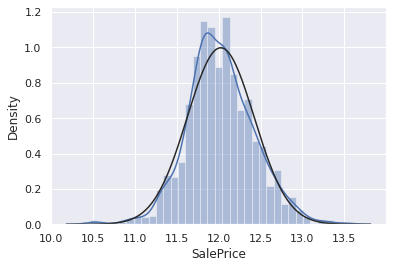

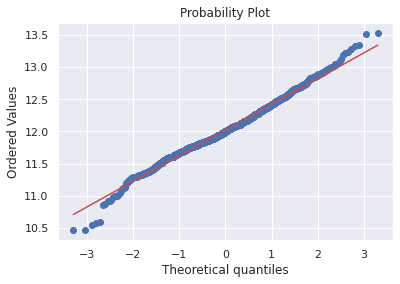

In [118]:
# Rcommended Article:https://codeburst.io/2-important-statistics-terms-you-need-to-know-in-data-science-skewness-and-kurtosis-388fef94eeaa:
# Log transformation to adjust positive skewness:

train_clean['SalePrice'] = np.log(train_clean['SalePrice'])
sns.distplot(train_clean['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train_clean['SalePrice'], plot=plt)

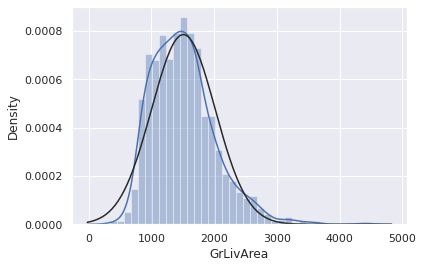

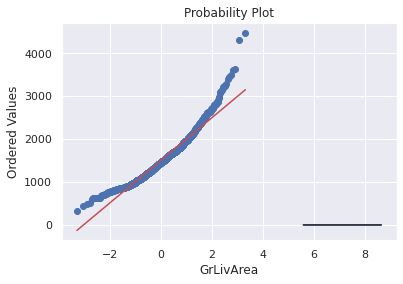

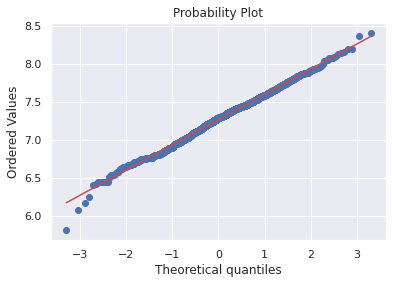

In [119]:
#GrLivArea Adjustment: histogram and normal probability plot
sns.distplot(train_clean['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(train_clean['GrLivArea'], plot=plt)

#data transformation:(skewness)
train_clean['GrLivArea'] = np.log(train_clean['GrLivArea'])
#Transformed histoogram and probability plot:
sns.distplot(train_clean['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(train_clean['GrLivArea'], plot=plt)

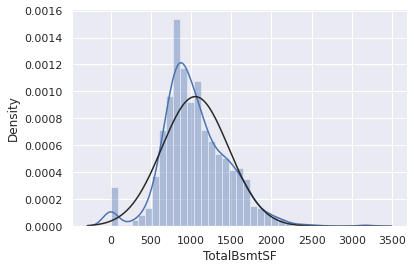

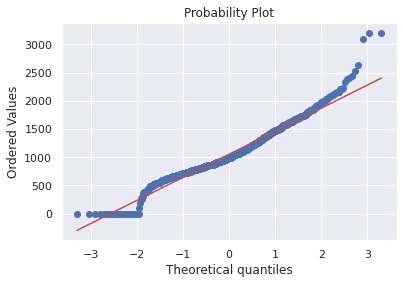

In [120]:
#TotalBasementSF:histogram and normal probability plot
#General Skewness, some houses with no basement,can't apply log transformation on zero values
#make log transformation only on non-zero values in another variable
sns.distplot(train_clean['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(train_clean['TotalBsmtSF'], plot=plt)

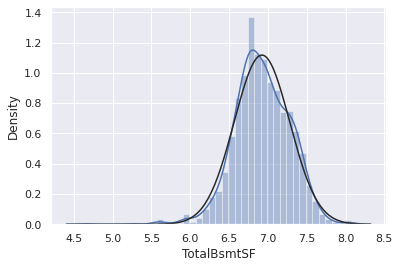

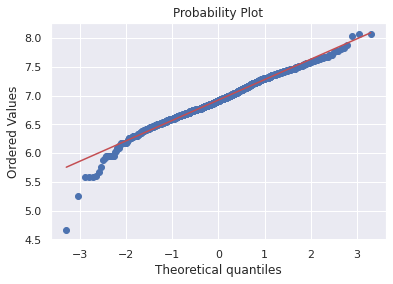

In [121]:
# TotalBasementSF:
# create column for new variable (one is enough because it's a binary categorical feature)
# if area > 0 it gets 1, if area = 0 it gets 0
train_clean['HasBsmt'] = pandas.Series(len(train_clean['TotalBsmtSF']), index=train_clean.index) #add new column with hashable name
train_clean['HasBsmt'] = 0 
train_clean.loc[train_clean['TotalBsmtSF'] > 0,'HasBsmt'] = 1 #set 'HasBsmt'to 1 where 'TotalBsmt' is non-zero,else 0
#transform data:(Apply log to TotalBsmtSF at the index where HasBsmt=1)
train_clean.loc[train_clean['HasBsmt']==1,'TotalBsmtSF'] = np.log(train_clean['TotalBsmtSF'])
#histogram and normal probability plot:
#Considering only those rows of train_clean where TotalBsmt is non-zero
sns.distplot(train_clean[train_clean['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(train_clean[train_clean['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

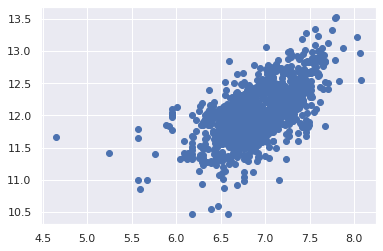

In [122]:
#scatter plot:(homoscedasticity)
plt.scatter(train_clean[train_clean['TotalBsmtSF']>0]['TotalBsmtSF'], train_clean[train_clean['TotalBsmtSF']>0]['SalePrice']);